### Operating Discriminator on Embedding Space instead of image space using **AUXILLARY CLASSIFIER GAN**

Checking if GAN works fine if discriminator is made to differenciate on embedding space rather than image space. The embedding function $\phi$ is fixed with random weights.

<img src = 'images/emGAN_AC.png' width=500 height=500/>

where **generator G** is fully convolutional as follows :-

<img src = 'images/emGAN_G.png' width=300 height=300/>

and **discriminator D** is densely connected as follows :-

<img src = 'images/emGAN_E.png' width=300 height=300/>

The **embedding network E** contains two convolutional layers initialized with random weights which are fixed. So, we can say that the embedding network is a fixed mapping from the output space of the generator to the input space of discriminator :- 

<img src = 'images/emGAN_D.png' width=300 height=300/>


## Some common functions

In [1]:
import numpy as np

import torch
from torch.autograd import Variable

import torch.nn as nn

# import activation functions
import torch.nn.functional as F

# import optimization functions
import torch.optim as optim

# torch vision functions
import torchvision


# add the loadDataset function [required as an interface to custom dataloaders]
import sys
sys.path.append('../')
from Datasets.loadDataset import loadDataset, getChannels
reload(sys.modules[loadDataset.__module__])


import matplotlib
import matplotlib.pyplot as plt

import time

In [2]:
def showTrainHist(trainHist):
    
    '''
    Plot Generator and Discriminator loss function
    '''
    x = range(len(trainHist['discLoss']))

    y1 = trainHist['discLoss']
    y2 = trainHist['genLoss']

    plt.plot(x, y1, label='D_loss')
    plt.plot(x, y2, label='G_loss')

    plt.xlabel('Iter')
    plt.ylabel('Loss')

    plt.legend(loc='upper right')
    plt.grid(True)
    plt.tight_layout()
    
    #folder = fileName.split('_')[0]
    
    #lossFolderName = resultDir+'loss/nonMMD'+'/'+folder+'/'
    #checkAndCreateFolder(lossFolderName)
    #lossFileName = lossFolderName+fileName+'_'+str(epoch)+'.png'
    #plt.savefig(lossFileName, bbox_inches='tight')

    plt.show()

In [3]:
# number of GPUs available
ngpu = 2

batchSize = 256

numNoiseChannels = 100
numGenFilter = 64
numDiscFilter = 64

learningRate = 0.0002
epochs = 100

cuda = 1

imageSize = 32

# for conditional GAN / auxillary classifier GAN
numClasses = 10

# for Wasserstein GAN
learningRate = 0.00005

#
discIter = 5

In [4]:
modelFolder = 'dummy'

GInitF = 'G_init.pt'
DInitF = 'D_init.pt'
EInitF = 'E_init.pt'

GFinalF = 'G_fin.pt'
DFinalF = 'D_fin.pt'
EFinalF = 'E_fin.pt'


def change():
    
    GInit = Generator(numNoiseChannels, numGenFilter, numPrimaryOutputChannels)
    PATH = modelFolder + '/' + GInitF
    GInit.load_state_dict(torch.load(PATH))

    DInit = Discriminator()
    PATH = modelFolder + '/' + DInitF
    DInit.load_state_dict(torch.load(PATH))

    EInit = EmbeddingNet(numPrimaryOutputChannels)
    PATH = modelFolder + '/' + EInitF
    EInit.load_state_dict(torch.load(PATH))
    
    
    GFin = Generator(numNoiseChannels, numGenFilter, numPrimaryOutputChannels)
    PATH = modelFolder + '/' + GFinalF
    GFin.load_state_dict(torch.load(PATH))

    DFin = Discriminator()
    PATH = modelFolder + '/' + DFinalF
    DFin.load_state_dict(torch.load(PATH))

    EFin = EmbeddingNet(numPrimaryOutputChannels)
    PATH = modelFolder + '/' + EFinalF
    EFin.load_state_dict(torch.load(PATH))
    
    GFlag = True    
    DFlag = True
    EFlag = True
    
    for m in GFin._modules:   
        if isinstance(GFin._modules[m], nn.ConvTranspose2d) or isinstance(GFin._modules[m],nn.BatchNorm2d):
            GFlag = GFlag and (GFin._modules[m].weight == GInit._modules[m].weight).data.all()
    

    for m in DFin._modules:
        if isinstance(DFin._modules[m], nn.Linear) or isinstance(DFin._modules[m],nn.BatchNorm2d):
            DFlag = DFlag and (DFin._modules[m].weight == DInit._modules[m].weight).data.all()
    
    
    for m in EFin._modules:
        
        if isinstance(EFin._modules[m], nn.Conv2d) or isinstance(EFin._modules[m],nn.BatchNorm2d):
            EFlag = EFlag and (EFin._modules[m].weight == EInit._modules[m].weight).data.all()

    if GFlag:
        print 'Generator: Weights are same'
    else:
        print 'Generator: Weights are different'
        
    if DFlag:
        print 'Discriminator: Weights are same'
    else:
        print 'Discriminator: Weights are different'

    if EFlag:
        print 'Embedding: Weights are same'
    else:
        print 'Embedding: Weights are different'

def change_C():
    
    GInit = Generator(numNoiseChannels, numClasses, numGenFilter, numPrimaryOutputChannels)
    PATH = modelFolder + '/' + GInitF
    GInit.load_state_dict(torch.load(PATH))

    DInit = Discriminator(numClasses)
    PATH = modelFolder + '/' + DInitF
    DInit.load_state_dict(torch.load(PATH))

    EInit = EmbeddingNet(numPrimaryOutputChannels)
    PATH = modelFolder + '/' + EInitF
    EInit.load_state_dict(torch.load(PATH))
    
    
    GFin = Generator(numNoiseChannels, numClasses, numGenFilter, numPrimaryOutputChannels)
    PATH = modelFolder + '/' + GFinalF
    GFin.load_state_dict(torch.load(PATH))

    DFin = Discriminator(numClasses)
    PATH = modelFolder + '/' + DFinalF
    DFin.load_state_dict(torch.load(PATH))

    EFin = EmbeddingNet(numPrimaryOutputChannels)
    PATH = modelFolder + '/' + EFinalF
    EFin.load_state_dict(torch.load(PATH))
    
    GFlag = True    
    DFlag = True
    EFlag = True
    
    for m in GFin._modules:   
        if isinstance(GFin._modules[m], nn.ConvTranspose2d) or isinstance(GFin._modules[m],nn.BatchNorm2d):
            GFlag = GFlag and (GFin._modules[m].weight == GInit._modules[m].weight).data.all()
    

    for m in DFin._modules:
        if isinstance(DFin._modules[m], nn.Linear) or isinstance(DFin._modules[m],nn.BatchNorm2d):
            DFlag = DFlag and (DFin._modules[m].weight == DInit._modules[m].weight).data.all()
    
    
    for m in EFin._modules:
        if isinstance(EFin._modules[m], nn.Conv2d) or isinstance(EFin._modules[m],nn.BatchNorm2d):
            EFlag = EFlag and (EFin._modules[m].weight == EInit._modules[m].weight).data.all()

    if GFlag:
        print 'Generator: Weights are same'
    else:
        print 'Generator: Weights are different'
        
    if DFlag:
        print 'Discriminator: Weights are same'
    else:
        print 'Discriminator: Weights are different'

    if EFlag:
        print 'Embedding: Weights are same'
    else:
        print 'Embedding: Weights are different'

This notebook contains of the below four experiments :-


- A **randomly** initialized embedding layer *E* with **AC-DC-GAN**
    - MNIST
    - SVHN
- A **triplet** loss initalized embedding layer *E* with **AC-DC-GAN**
    - MNIST ( $\boldsymbol{\theta}$ from the trained network )
    - SVHN  ($\boldsymbol{\phi}$ from the trained network)
- A **contrastive** initialized embedding layer *E* with **AC-DC-GAN**
    - MNIST ($\boldsymbol{\theta}$ from the trained network)
    - SVHN  ($\boldsymbol{\phi}$ from the trained network)

## Training function for Auxillary Classifier GAN

In [ ]:
# train using the primary class only 

def train_AC(primaryTrainLoader,
          embeddingNetwork,
          learningRate = 0.0002,
          epochs=20,
          embeddingNetWt=0):
    
    G = Generator(numNoiseChannels, 
                  numClasses, 
                  numGenFilter, 
                  numPrimaryOutputChannels)
    D = Discriminator(numClasses)
    E = embeddingNetwork

    #initialize weights 
    G.weight_init(mean=0.0, std=0.02)
    D.weight_init(mean=0.0, std=0.02)
    
    if embeddingNetWt==1:
        E = embeddingNetwork(numPrimaryOutputChannels)
        E.weight_init(mean=0.0, std=0.02)
        
    PATH = modelFolder+'/' + GInitF
    torch.save(G.state_dict(), PATH)
    PATH = modelFolder+'/' + DInitF
    torch.save(D.state_dict(), PATH)
    PATH = modelFolder+'/' + EInitF
    torch.save(E.state_dict(), PATH)
    
    
    # define loss function and optimizers
    lossFunction = nn.BCELoss()
    
    # classification loss as an auxillary task
    classifyLossFunction = nn.NLLLoss()


    genOptimizer = optim.Adam(G.parameters(),
                              lr=learningRate,
                              betas = (0.5,0.999))
    discOptimizer = optim.Adam(D.parameters(),
                               lr=learningRate,
                               betas = (0.5,0.999))
    
    # real input to the discriminator pertaining primary class
    discRealInputPrimary = torch.FloatTensor(batchSize,
                                      numPrimaryOutputChannels,
                                      imageSize,
                                      imageSize)
    

    
    # label is 1 for real examples and 0 for generated examples
    discRealLabel = torch.FloatTensor(batchSize)
    discRealLabel.fill_(1)
    
    discFakeInput = torch.FloatTensor(batchSize,
                                      numNoiseChannels,
                                      1,
                                      1)
    discFakeLabel = torch.FloatTensor(batchSize)
    discFakeLabel.fill_(0)
    
    discRealInputClass = torch.zeros(batchSize,
                                     numClasses)
    
    discFakeInputClass = torch.zeros( batchSize,
                                      numClasses,
                                      1,
                                      1)    
    
    

    # to check the formation of image, we define a fixed noise vector
    numElementsNeededPerClass = 10
    
    fixedNoise = torch.randn(numElementsNeededPerClass*numClasses,
                             numNoiseChannels,
                             1,
                             1)
    
    # class from which the GAN should output a distribution
    fixedNoiseClass = torch.zeros(numElementsNeededPerClass*numClasses,
                                  numClasses,
                                  1,
                                  1)
    
    classIndex = torch.zeros(numElementsNeededPerClass,1)
    for i in range(numClasses-1):
        temp = torch.ones(numElementsNeededPerClass,1)+i
        classIndex = torch.cat([classIndex, temp], 0)
    
    fixedNoiseClass = fixedNoiseClass.squeeze().scatter_(1, classIndex.type(torch.LongTensor), 1)
    fixedNoiseClass = fixedNoiseClass.view(-1,
                                           numClasses,
                                           1,
                                           1)
    
    
    # can take the oneHot representation to feed into generator and discriminator directly from here
    oneHotGen = torch.zeros(numClasses, numClasses)
    oneHotGen = oneHotGen.scatter_(1, torch.LongTensor([i for i in range(numClasses)]).view(numClasses,1), 1).view(numClasses, numClasses, 1, 1)
    oneHotDisc = oneHotGen.squeeze()
      
    if cuda:
        
        G = G.cuda()
        D = D.cuda()
        E = E.cuda()
        
        lossFunction = lossFunction.cuda()
        classifyLossFunction = classifyLossFunction.cuda()
        
        discRealInputPrimary = discRealInputPrimary.cuda()
        
        discRealLabel = discRealLabel.cuda()
        
        discRealInputClass = discRealInputClass.cuda()
        discFakeInputClass = discFakeInputClass.cuda()
        
        discFakeInput = discFakeInput.cuda()
        discFakeLabel = discFakeLabel.cuda()
        
        fixedNoise = fixedNoise.cuda()
        fixedNoiseClass = fixedNoiseClass.cuda()
        
        
        
    fixedNoiseV = Variable(fixedNoise)
    
    fixedNoiseClassV = Variable(fixedNoiseClass)

    # loggers
    trainHist = {}
    trainHist['discLoss'] = [] 
    trainHist['genLoss'] = []
    trainHist['perEpochTime'] = []
    trainHist['totalTime'] = []
    
    # train using theta - the embedding of primary class only
    for epoch in range(epochs):
        
        generatorLosses = []
        discriminatorLosses = []
        
        primaryEpochstartTime = time.time()
        


        for i,data in enumerate(primaryTrainLoader, 0):

            # train discriminator D

            # set the gradients in computation graph of discriminator to be 0
            D.zero_grad()
            dataInstance, dataClass = data

            # one-hot encoding for discriminator class input
            dataClassOH = oneHotDisc[dataClass]

            if cuda:
                dataInstance = dataInstance.cuda()
                dataClass = dataClass.cuda()
                dataClassOH = dataClassOH.cuda()


            #print discRealInputPrimary.shape, dataInstance.shape

            # train discriminator on real classes
            discRealInputPrimary.copy_(dataInstance)
            discRealInputClass.copy_(dataClassOH)

            dataClassV = Variable(dataClass)
            discRealInputPrimaryV = Variable(discRealInputPrimary)
            discRealInputClassV = Variable(discRealInputClass)
            discRealLabelV = Variable(discRealLabel)


            ## given embedding of the real data instead of image to disceriminator
            ## returns a pytorch Variable batchSize x 84 ie theta for particular batch
            #print discRealInputV
            discRealInputEmbedding = E(discRealInputPrimaryV)

            discRealOutput, discClassOutput = D(discRealInputEmbedding,
                               discRealInputClassV)

            #print discClassOutput.data.shape, dataClassV.data.shape
            discLossReal = lossFunction(discRealOutput,
                                        discRealLabelV) + classifyLossFunction(discClassOutput, 
                                                                                  dataClassV)

            # calculate the gradients for nodes of computation graph
            discLossReal.backward()

            # train discriminator on fake classes
            #  p=getProbDist(primaryInstanceList)
            dataFakeClass = torch.from_numpy(np.random.choice(numClasses, batchSize))
            discFakeInputClass = oneHotDisc[dataFakeClass]
            genFakeInputClass = oneHotGen[dataFakeClass]

            if cuda:
                dataFakeClass = dataFakeClass.cuda()
                discFakeInputClass = discFakeInputClass.cuda()
                genFakeInputClass = genFakeInputClass.cuda()


            discFakeInput.normal_(0,1)

            dataFakeClassV = Variable(dataFakeClass)
            discFakeInputClassV= Variable(discFakeInputClass)
            genFakeInputClassV = Variable(genFakeInputClass)
            discFakeInputV = Variable(discFakeInput)
            discFakeLabelV = Variable(discFakeLabel)


            genFakeOutput = G(discFakeInputV,
                              genFakeInputClassV)
            #genFakeOutput = genFakeOutput.view(batchSize,-1)

            # get the 84 dimensional embedding of generator output
            genFakeOutputEmbedding = E(genFakeOutput)

            # detach the graph prior to D. So what weights in G do not get updated
            #print genFakeOutput.data.shape, discFakeInputClassV.data.shape

            discFakeOutput, discClassOutput = D(genFakeOutputEmbedding.detach(),
                               discFakeInputClassV)

            discLossFake = lossFunction(discFakeOutput,
                                        discFakeLabelV) + classifyLossFunction(discClassOutput,
                                                                               dataFakeClassV)

            # calculate the gradients for nodes of computation graph
            discLossFake.backward()

            # log the loss for discriminator
            discriminatorLosses.append((discLossReal+discLossFake).data[0])

            # update the weights
            discOptimizer.step()

            # train generator with discriminator feedback
            G.zero_grad()


            # have to freeze weights of theta
            discFakeOutput, discClassOutput = D(genFakeOutputEmbedding,
                               discFakeInputClassV)

            genLossFake = lossFunction(discFakeOutput, 
                                       discRealLabelV) + classifyLossFunction(discClassOutput,
                                                                              dataFakeClassV)

            genLossFake.backward()
            genOptimizer.step()

            # log the loss for generator
            generatorLosses.append(genLossFake.data[0])

    # create an image for every epoch
    # generate samples from trained generator
        epochEndTime = time.time()
        perEpochTime = epochEndTime - primaryEpochstartTime 
        discLoss = torch.mean(torch.FloatTensor(discriminatorLosses))
        genLoss = torch.mean(torch.FloatTensor(generatorLosses))  
        trainHist['discLoss'].append(discLoss)
        trainHist['genLoss'].append(genLoss)
        print ('Epoch : [%d/%d] time: %.2f, loss_d: %.3f, loss_g: %.3f'% (epoch+1,
                                                                 epochs,
                                                                 perEpochTime,
                                                                 discLoss,
                                                                 genLoss))    
    
    genImage = G(fixedNoiseV,
                 fixedNoiseClassV)
    genImage = genImage.data
    genImage = genImage.cpu()

    genImage = torchvision.utils.make_grid(genImage, nrow=10)
    genImage = (genImage/2) + 0.5
    genImage = genImage.permute(1,2,0)
    genImage = genImage.numpy()

    plt.figure()
    fig = plt.figure(figsize=(20,10))
    plt.imshow(genImage)
    plt.axis('off')

    txt = 'Epoch: '+ str(epoch+1)
    fig.text(.45,.05,txt)
    plt.show()
    
    showTrainHist(trainHist)
    
    PATH = modelFolder+'/' + GFinalF
    torch.save(G.state_dict(), PATH)
    PATH = modelFolder+'/' + DFinalF
    torch.save(D.state_dict(), PATH)
    PATH = modelFolder+'/' + EFinalF
    torch.save(E.state_dict(), PATH)

In [23]:
from model_exp0a_ac import Generator, Discriminator, EmbeddingNet

#### MNIST Dataset


In [24]:
# define theta and phi embedding networks according to the loss used ie contrastive or triplet
primaryDataset = 'MNIST'
numPrimaryOutputChannels = getChannels(primaryDataset)

classes = [0,1,2,3,4,5,6,7,8,9]
instances = [7000 for i in range(10)]
kwargs = {'num_workers': 1, 'pin_memory': True, 'drop_last':True} if cuda else {}

# raw test data, seperate for both the primary and helper class
trainDatasetPrimary = loadDataset(primaryDataset, classes, instances,'train')

# raw test data, seperate for both the primary and helper class
testDatasetPrimary = loadDataset(primaryDataset, classes, instances,'test')

primaryTrainLoader = torch.utils.data.DataLoader(trainDatasetPrimary, batch_size=batchSize, shuffle=True, **kwargs)

# raw test data, seperate for both the primary and helper class
primaryTestLoader = torch.utils.data.DataLoader(testDatasetPrimary, batch_size=batchSize, shuffle=True, **kwargs)

In [25]:
embeddingNet = EmbeddingNet

Epoch : [1/5] time: 8.35, loss_d: 0.811, loss_g: 0.402
Epoch : [2/5] time: 8.39, loss_d: 0.235, loss_g: 0.121
Epoch : [3/5] time: 8.39, loss_d: -0.275, loss_g: -0.137
Epoch : [4/5] time: 8.38, loss_d: -0.507, loss_g: -0.253
Epoch : [5/5] time: 8.39, loss_d: -0.563, loss_g: -0.281


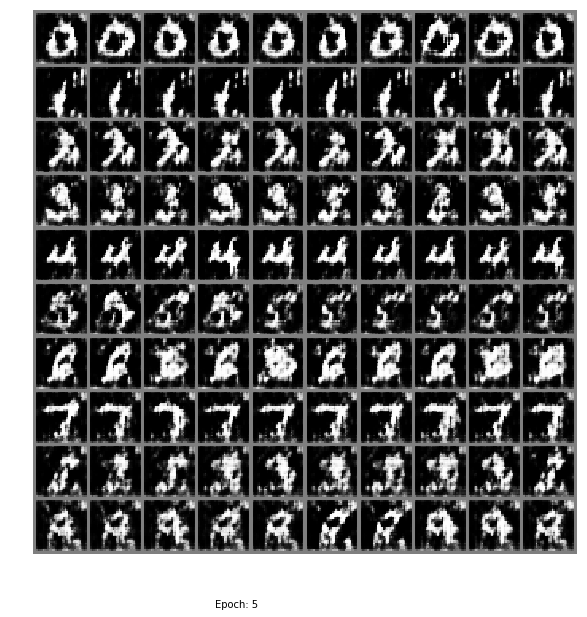

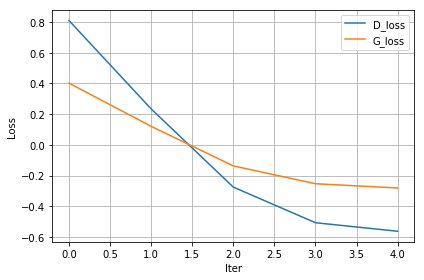

In [26]:
train_AC(primaryTrainLoader, embeddingNet, epochs=5, embeddingNetWt=1)

Epoch : [1/30] time: 8.49, loss_d: 0.862, loss_g: 0.430
Epoch : [2/30] time: 8.33, loss_d: 0.175, loss_g: 0.087
Epoch : [3/30] time: 8.37, loss_d: -0.326, loss_g: -0.162
Epoch : [4/30] time: 8.38, loss_d: -0.512, loss_g: -0.256
Epoch : [5/30] time: 8.55, loss_d: -0.564, loss_g: -0.282
Epoch : [6/30] time: 9.47, loss_d: -0.584, loss_g: -0.292
Epoch : [7/30] time: 8.59, loss_d: -0.594, loss_g: -0.296
Epoch : [8/30] time: 8.60, loss_d: -0.601, loss_g: -0.299
Epoch : [9/30] time: 8.63, loss_d: -0.605, loss_g: -0.300
Epoch : [10/30] time: 8.63, loss_d: -0.608, loss_g: -0.301
Epoch : [11/30] time: 8.60, loss_d: -0.612, loss_g: -0.299
Epoch : [12/30] time: 8.59, loss_d: -0.614, loss_g: -0.298
Epoch : [13/30] time: 8.64, loss_d: -0.619, loss_g: -0.294
Epoch : [14/30] time: 8.64, loss_d: -0.622, loss_g: -0.291
Epoch : [15/30] time: 8.65, loss_d: -0.630, loss_g: -0.285
Epoch : [16/30] time: 8.56, loss_d: -0.637, loss_g: -0.281
Epoch : [17/30] time: 8.58, loss_d: -0.651, loss_g: -0.266
Epoch : [1

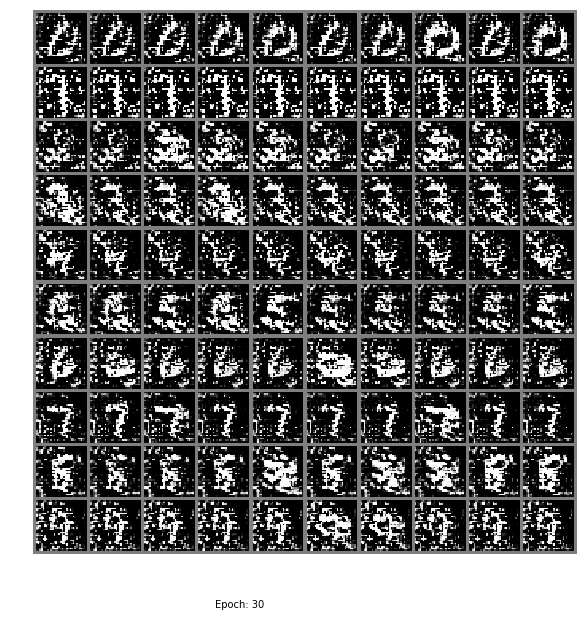

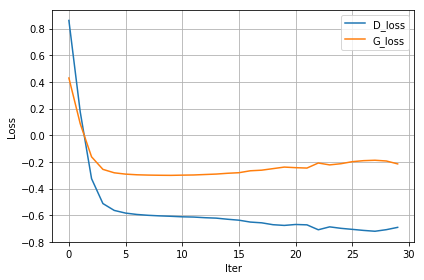

In [27]:
train_AC(primaryTrainLoader, embeddingNet, epochs=30, embeddingNetWt=1)

#### SVHN Dataset

In [28]:
# define theta and phi embedding networks according to the loss used ie contrastive or triplet
primaryDataset = 'SVHN'
numPrimaryOutputChannels = getChannels(primaryDataset)

classes = [0,1,2,3,4,5,6,7,8,9]
instances = [7000 for i in range(10)]
kwargs = {'num_workers': 1, 'pin_memory': True, 'drop_last':True} if cuda else {}

# raw test data, seperate for both the primary and helper class
trainDatasetPrimary = loadDataset(primaryDataset, classes, instances,'train')

# raw test data, seperate for both the primary and helper class
testDatasetPrimary = loadDataset(primaryDataset, classes, instances,'test')

primaryTrainLoader = torch.utils.data.DataLoader(trainDatasetPrimary, batch_size=batchSize, shuffle=True, **kwargs)

# raw test data, seperate for both the primary and helper class
primaryTestLoader = torch.utils.data.DataLoader(testDatasetPrimary, batch_size=batchSize, shuffle=True, **kwargs)

In [29]:
embeddingNet = EmbeddingNet

Epoch : [1/5] time: 10.25, loss_d: 0.850, loss_g: 0.424
Epoch : [2/5] time: 10.14, loss_d: 0.197, loss_g: 0.106
Epoch : [3/5] time: 10.20, loss_d: -0.267, loss_g: -0.124
Epoch : [4/5] time: 10.17, loss_d: -0.501, loss_g: -0.241
Epoch : [5/5] time: 10.24, loss_d: -0.587, loss_g: -0.260


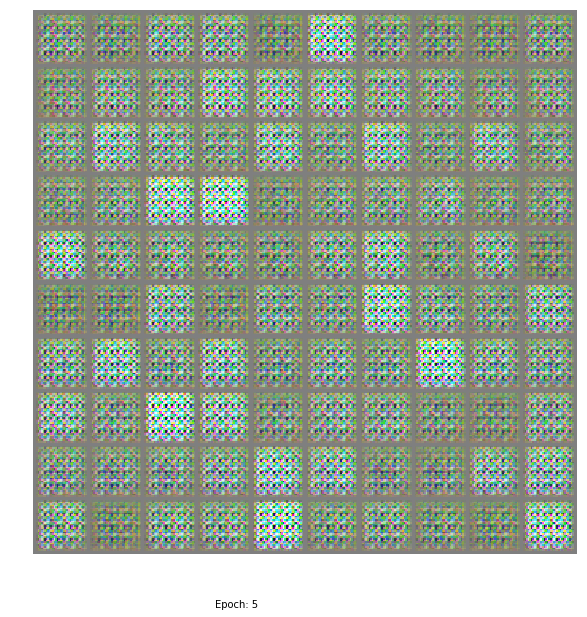

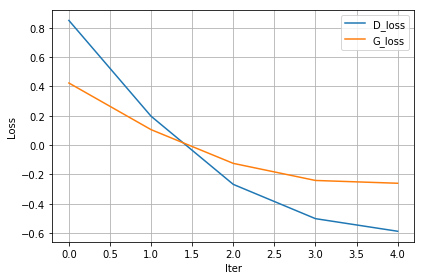

In [30]:
train_AC(primaryTrainLoader, embeddingNet, epochs=5, embeddingNetWt=1)

Epoch : [1/30] time: 10.28, loss_d: 0.856, loss_g: 0.435
Epoch : [2/30] time: 10.13, loss_d: 0.250, loss_g: 0.129
Epoch : [3/30] time: 10.17, loss_d: -0.323, loss_g: -0.157
Epoch : [4/30] time: 10.16, loss_d: -0.531, loss_g: -0.244
Epoch : [5/30] time: 10.18, loss_d: -0.612, loss_g: -0.243
Epoch : [6/30] time: 10.15, loss_d: -0.703, loss_g: -0.197
Epoch : [7/30] time: 10.28, loss_d: -0.790, loss_g: -0.132
Epoch : [8/30] time: 10.34, loss_d: -0.884, loss_g: -0.052
Epoch : [9/30] time: 10.33, loss_d: -0.954, loss_g: 0.016
Epoch : [10/30] time: 10.34, loss_d: -1.038, loss_g: 0.106
Epoch : [11/30] time: 10.42, loss_d: -1.079, loss_g: 0.155
Epoch : [12/30] time: 11.36, loss_d: -1.080, loss_g: 0.179
Epoch : [13/30] time: 10.39, loss_d: -1.146, loss_g: 0.262
Epoch : [14/30] time: 10.38, loss_d: -1.168, loss_g: 0.308
Epoch : [15/30] time: 10.29, loss_d: -1.204, loss_g: 0.360
Epoch : [16/30] time: 10.32, loss_d: -1.213, loss_g: 0.403
Epoch : [17/30] time: 10.32, loss_d: -1.228, loss_g: 0.436
Ep

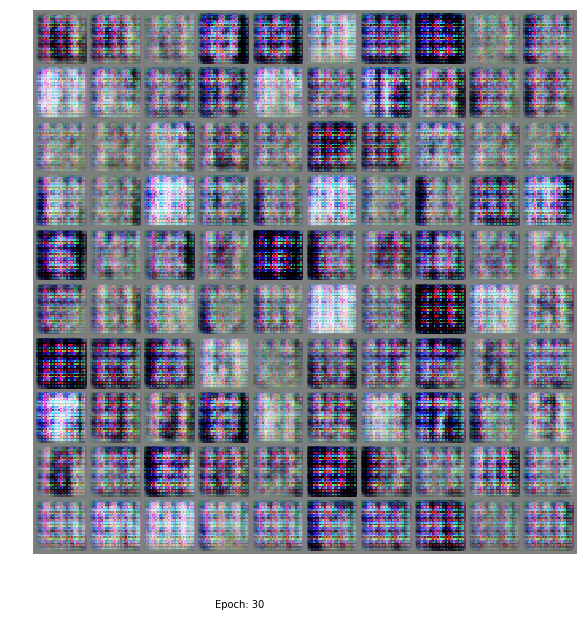

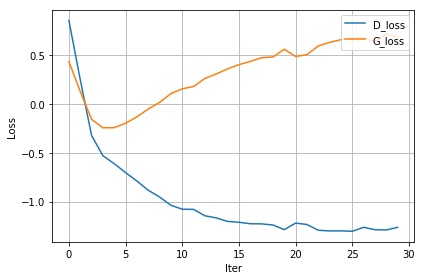

In [31]:
train_AC(primaryTrainLoader, embeddingNet, epochs=30, embeddingNetWt=1)

Epoch : [1/100] time: 10.25, loss_d: 0.790, loss_g: 0.402
Epoch : [2/100] time: 10.12, loss_d: 0.100, loss_g: 0.057
Epoch : [3/100] time: 10.15, loss_d: -0.233, loss_g: -0.110
Epoch : [4/100] time: 10.17, loss_d: -0.477, loss_g: -0.226
Epoch : [5/100] time: 11.10, loss_d: -0.583, loss_g: -0.249
Epoch : [6/100] time: 10.21, loss_d: -0.658, loss_g: -0.224
Epoch : [7/100] time: 10.21, loss_d: -0.735, loss_g: -0.179
Epoch : [8/100] time: 10.24, loss_d: -0.809, loss_g: -0.127
Epoch : [9/100] time: 10.31, loss_d: -0.897, loss_g: -0.053
Epoch : [10/100] time: 10.35, loss_d: -0.919, loss_g: -0.018
Epoch : [11/100] time: 10.30, loss_d: -1.012, loss_g: 0.068
Epoch : [12/100] time: 10.27, loss_d: -1.027, loss_g: 0.100
Epoch : [13/100] time: 10.32, loss_d: -1.070, loss_g: 0.154
Epoch : [14/100] time: 10.29, loss_d: -1.113, loss_g: 0.219
Epoch : [15/100] time: 10.34, loss_d: -1.127, loss_g: 0.253
Epoch : [16/100] time: 10.90, loss_d: -1.155, loss_g: 0.297
Epoch : [17/100] time: 10.70, loss_d: -1.18

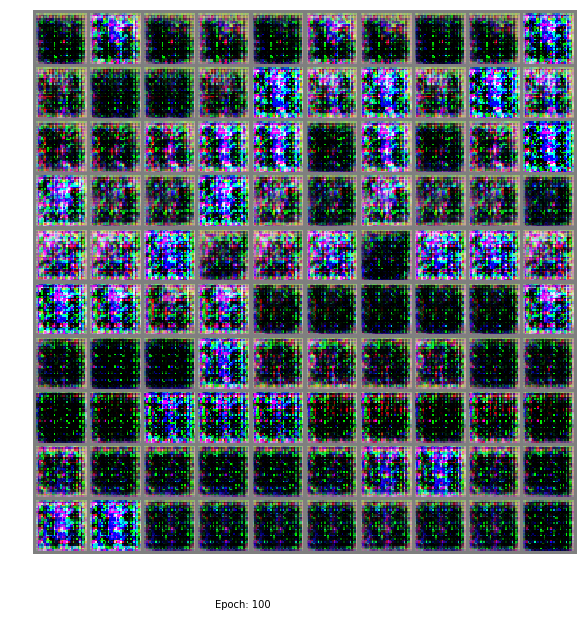

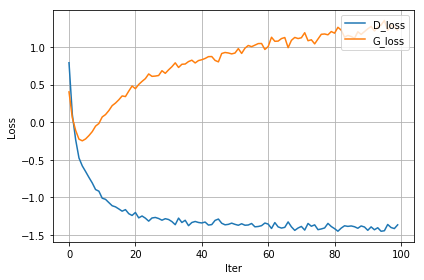

In [32]:
train_AC(primaryTrainLoader, embeddingNet, epochs=100, embeddingNetWt=1)

## Triplet Domain Embedding E

In [13]:
# we will now be using LeNet instead of embeddingNet
from networks import LeNet, TripletNet

# define theta and phi embedding networks according to the loss used ie contrastive or triplet
primaryDataset = 'MNIST'
helperDataset = 'SVHN'
numClasses = 10
cuda = 1

# theta and phi are defined based on the number of channels in primary and helper datasets
theta = LeNet(getChannels(primaryDataset))
phi = LeNet(getChannels(helperDataset))

# load the weights of neural networks $\theta$ and $\phi$ saved while training using Siamese and Triplet loss
model = TripletNet(theta, phi)

if cuda:
    model = model.cuda()

modelFoldername = 'models'
modelFileName = primaryDataset+'_'+helperDataset+'_'+'triplet'+'.pt'

PATH = modelFoldername + '/' + modelFileName
model.load_state_dict(torch.load(PATH))

# setting the require_grad as False for all parameters pertaining thera and phi
for param in model.parameters():
    param.require_grad=False

### MNIST Dataset

In [14]:
# define theta and phi embedding networks according to the loss used ie contrastive or triplet
primaryDataset = 'MNIST'
numPrimaryOutputChannels = getChannels(primaryDataset)

classes = [0,1,2,3,4,5,6,7,8,9]
instances = [7000 for i in range(10)]
kwargs = {'num_workers': 1, 'pin_memory': True, 'drop_last':True} if cuda else {}

# raw test data, seperate for both the primary and helper class
trainDatasetPrimary = loadDataset(primaryDataset, classes, instances,'train')

# raw test data, seperate for both the primary and helper class
testDatasetPrimary = loadDataset(primaryDataset, classes, instances,'test')

primaryTrainLoader = torch.utils.data.DataLoader(trainDatasetPrimary, batch_size=batchSize, shuffle=True, **kwargs)

# raw test data, seperate for both the primary and helper class
primaryTestLoader = torch.utils.data.DataLoader(testDatasetPrimary, batch_size=batchSize, shuffle=True, **kwargs)

In [15]:
embeddingNet = model.embedding_net_1

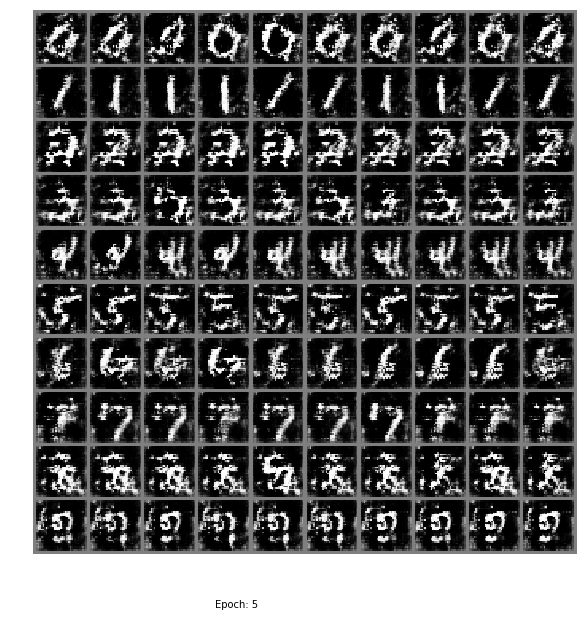

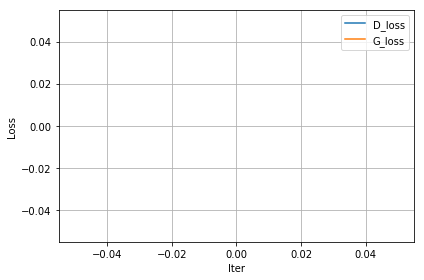

In [17]:
train_AC(primaryTrainLoader, embeddingNet, epochs=5, embeddingNetWt=0)

### SVHN Dataset

In [18]:
# define theta and phi embedding networks according to the loss used ie contrastive or triplet
primaryDataset = 'SVHN'
numPrimaryOutputChannels = getChannels(primaryDataset)

classes = [0,1,2,3,4,5,6,7,8,9]
instances = [7000 for i in range(10)]
kwargs = {'num_workers': 1, 'pin_memory': True, 'drop_last':True} if cuda else {}

# raw test data, seperate for both the primary and helper class
trainDatasetPrimary = loadDataset(primaryDataset, classes, instances,'train')

# raw test data, seperate for both the primary and helper class
testDatasetPrimary = loadDataset(primaryDataset, classes, instances,'test')

primaryTrainLoader = torch.utils.data.DataLoader(trainDatasetPrimary, batch_size=batchSize, shuffle=True, **kwargs)

# raw test data, seperate for both the primary and helper class
primaryTestLoader = torch.utils.data.DataLoader(testDatasetPrimary, batch_size=batchSize, shuffle=True, **kwargs)

In [19]:
embeddingNet = model.embedding_net_2

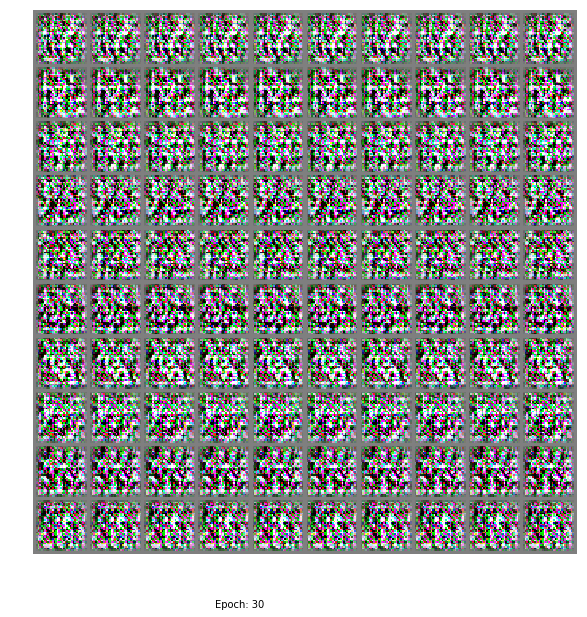

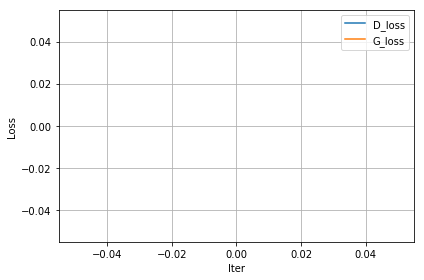

In [20]:
train_AC(primaryTrainLoader, embeddingNet, epochs=30, embeddingNetWt=0)

## Contrastive Domain Embedding E

In [33]:
# we will now be using LeNet instead of embeddingNet
from networks import LeNet, SiameseNet

# define theta and phi embedding networks according to the loss used ie contrastive or triplet
primaryDataset = 'MNIST'
helperDataset = 'SVHN'
numClasses = 10
cuda = 1

# theta and phi are defined based on the number of channels in primary and helper datasets
theta = LeNet(getChannels(primaryDataset))
phi = LeNet(getChannels(helperDataset))

# load the weights of neural networks $\theta$ and $\phi$ saved while training using Siamese and Triplet loss
model = SiameseNet(theta, phi)

if cuda:
    model = model.cuda()

modelFoldername = 'models'
modelFileName = primaryDataset+'_'+helperDataset+'_'+'contrastive'+'.pt'

PATH = modelFoldername + '/' + modelFileName
model.load_state_dict(torch.load(PATH))

# setting the require_grad as False for all parameters pertaining thera and phi
for param in model.parameters():
    param.require_grad=False

### MNIST Dataset

In [34]:
# define theta and phi embedding networks according to the loss used ie contrastive or triplet
primaryDataset = 'MNIST'
numPrimaryOutputChannels = getChannels(primaryDataset)

classes = [0,1,2,3,4,5,6,7,8,9]
instances = [7000 for i in range(10)]
kwargs = {'num_workers': 1, 'pin_memory': True, 'drop_last':True} if cuda else {}

# raw test data, seperate for both the primary and helper class
trainDatasetPrimary = loadDataset(primaryDataset, classes, instances,'train')

# raw test data, seperate for both the primary and helper class
testDatasetPrimary = loadDataset(primaryDataset, classes, instances,'test')

primaryTrainLoader = torch.utils.data.DataLoader(trainDatasetPrimary, batch_size=batchSize, shuffle=True, **kwargs)

# raw test data, seperate for both the primary and helper class
primaryTestLoader = torch.utils.data.DataLoader(testDatasetPrimary, batch_size=batchSize, shuffle=True, **kwargs)

In [35]:
embeddingNet = model.embedding_net_1

Epoch : [1/30] time: 8.51, loss_d: 0.857, loss_g: 0.435
Epoch : [2/30] time: 8.37, loss_d: 0.143, loss_g: 0.066
Epoch : [3/30] time: 8.41, loss_d: -0.232, loss_g: -0.112
Epoch : [4/30] time: 8.40, loss_d: -0.478, loss_g: -0.237
Epoch : [5/30] time: 8.39, loss_d: -0.558, loss_g: -0.277
Epoch : [6/30] time: 8.40, loss_d: -0.582, loss_g: -0.289
Epoch : [7/30] time: 9.03, loss_d: -0.594, loss_g: -0.293
Epoch : [8/30] time: 8.39, loss_d: -0.644, loss_g: -0.257
Epoch : [9/30] time: 8.40, loss_d: -0.657, loss_g: -0.245
Epoch : [10/30] time: 8.45, loss_d: -0.637, loss_g: -0.267
Epoch : [11/30] time: 8.57, loss_d: -0.651, loss_g: -0.260
Epoch : [12/30] time: 8.59, loss_d: -0.652, loss_g: -0.260
Epoch : [13/30] time: 8.53, loss_d: -0.651, loss_g: -0.258
Epoch : [14/30] time: 8.54, loss_d: -0.651, loss_g: -0.259
Epoch : [15/30] time: 8.55, loss_d: -0.675, loss_g: -0.239
Epoch : [16/30] time: 8.54, loss_d: -0.677, loss_g: -0.234
Epoch : [17/30] time: 8.60, loss_d: -0.752, loss_g: -0.174
Epoch : [1

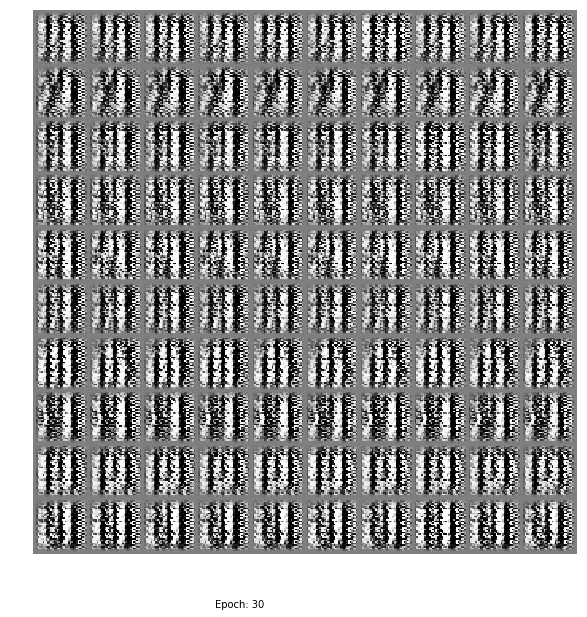

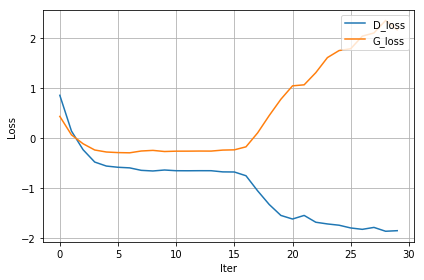

In [36]:
train_AC(primaryTrainLoader, embeddingNet, epochs=30, embeddingNetWt=0)

### SVHN Dataset

In [37]:
# define theta and phi embedding networks according to the loss used ie contrastive or triplet
primaryDataset = 'SVHN'
numPrimaryOutputChannels = getChannels(primaryDataset)

classes = [0,1,2,3,4,5,6,7,8,9]
instances = [7000 for i in range(10)]
kwargs = {'num_workers': 1, 'pin_memory': True, 'drop_last':True} if cuda else {}

# raw test data, seperate for both the primary and helper class
trainDatasetPrimary = loadDataset(primaryDataset, classes, instances,'train')

# raw test data, seperate for both the primary and helper class
testDatasetPrimary = loadDataset(primaryDataset, classes, instances,'test')

primaryTrainLoader = torch.utils.data.DataLoader(trainDatasetPrimary, batch_size=batchSize, shuffle=True, **kwargs)

# raw test data, seperate for both the primary and helper class
primaryTestLoader = torch.utils.data.DataLoader(testDatasetPrimary, batch_size=batchSize, shuffle=True, **kwargs)

In [38]:
embeddingNet = model.embedding_net_2

Epoch : [1/30] time: 10.26, loss_d: 0.860, loss_g: 0.448
Epoch : [2/30] time: 10.16, loss_d: 0.165, loss_g: 0.089
Epoch : [3/30] time: 10.54, loss_d: -0.315, loss_g: -0.148
Epoch : [4/30] time: 10.52, loss_d: -0.511, loss_g: -0.247
Epoch : [5/30] time: 10.24, loss_d: -0.581, loss_g: -0.264
Epoch : [6/30] time: 10.24, loss_d: -0.645, loss_g: -0.243
Epoch : [7/30] time: 10.22, loss_d: -0.722, loss_g: -0.198
Epoch : [8/30] time: 10.22, loss_d: -0.814, loss_g: -0.128
Epoch : [9/30] time: 10.24, loss_d: -0.887, loss_g: -0.061
Epoch : [10/30] time: 10.23, loss_d: -0.972, loss_g: 0.022
Epoch : [11/30] time: 10.23, loss_d: -1.018, loss_g: 0.081
Epoch : [12/30] time: 10.24, loss_d: -1.042, loss_g: 0.127
Epoch : [13/30] time: 10.24, loss_d: -1.103, loss_g: 0.198
Epoch : [14/30] time: 10.21, loss_d: -1.125, loss_g: 0.244
Epoch : [15/30] time: 10.91, loss_d: -1.187, loss_g: 0.308
Epoch : [16/30] time: 10.21, loss_d: -1.213, loss_g: 0.369
Epoch : [17/30] time: 10.23, loss_d: -1.180, loss_g: 0.367
E

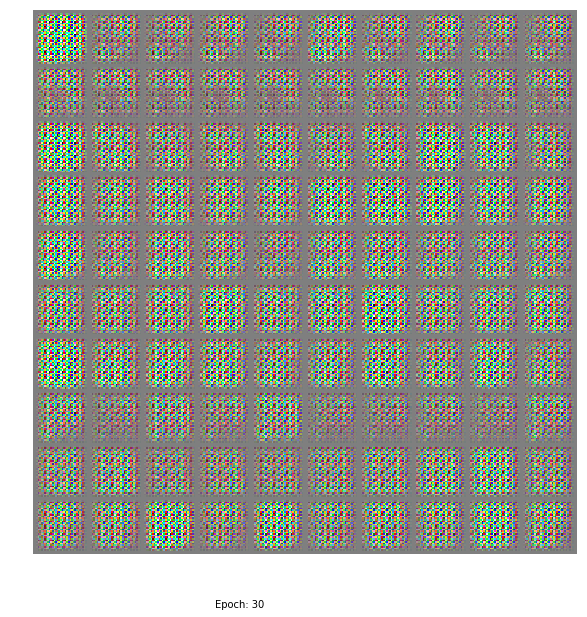

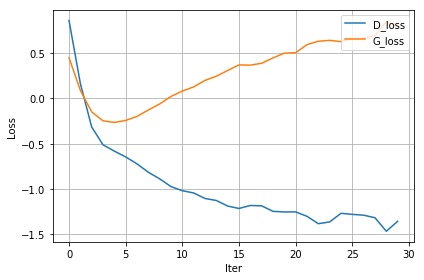

In [39]:
train_AC(primaryTrainLoader, embeddingNet, epochs=30, embeddingNetWt=0)